In [1]:
import sys
from pathlib import Path

# Get the absolute path to the base directory (one level up from notebook dir)
BASE_DIR = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent

# Add to sys.path if not already present
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# Now you can import directly
from zeromodel import ZeroModel


2025-08-13 21:20:44,965 - zeromodel.config - DEBUG - Added console logging handler
2025-08-13 21:20:44,967 - zeromodel.config - DEBUG - Added file logging handler: zeromodel.log
2025-08-13 21:20:44,968 - zeromodel.config - INFO - Logging configured at level: DEBUG
2025-08-13 21:20:44,968 - zeromodel.config - DEBUG - Configuration details:
2025-08-13 21:20:44,969 - zeromodel.config - DEBUG -   core: {'use_duckdb': False, 'duckdb_bypass_threshold': 0.5, 'precision': 8, 'normalize_inputs': True, 'nonlinearity_handling': 'auto', 'cache_preprocessed_vpm': True, 'max_cached_tasks': 100, 'default_output_precision': 'float32'}
2025-08-13 21:20:44,969 - zeromodel.config - DEBUG -   edge: {'enabled': False, 'default_tile_size': 3, 'output_precision': 'uint8', 'max_memory_usage': 25600}
2025-08-13 21:20:44,971 - zeromodel.config - DEBUG -   hierarchical: {'num_levels': 3, 'zoom_factor': 3, 'wavelet_type': 'haar'}
2025-08-13 21:20:44,971 - zeromodel.config - DEBUG -   logging: {'level': 'DEBUG', '

2025-08-13 21:20:44,973 - zeromodel.config - DEBUG - Core processing: use_duckdb=False, precision=8
2025-08-13 21:20:44,974 - zeromodel.config - DEBUG - Edge mode: disabled
2025-08-13 21:20:44,974 - zeromodel.config - INFO - Configuration manager initialized
2025-08-13 21:20:44,974 - zeromodel.config - DEBUG - Global configuration initialized
2025-08-13 21:20:45,073 - zeromodel.core - INFO - [prepare] total done


In [2]:
# some imports we will be using in this demonstration
import time, hashlib
from IPython.display import Image, display 
import numpy as np
from io import BytesIO
from PIL import Image
from zeromodel.provenance.core import (
    tensor_to_vpm, vpm_to_tensor,
    create_vpf, embed_vpf, extract_vpf, verify_vpf,
    vpm_logic_and, vpm_logic_or, vpm_logic_not, vpm_logic_xor
)


### 1.See AI think
Record a few “tiles of thought” and GIF them.


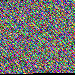

In [ ]:
tiles = []
for step in range(8):
    scores = np.random.rand(64, 64).astype(np.float32) * (step+1)/8.0
    tiles.append(tensor_to_vpm(scores))

buf = BytesIO(); tiles[0].save(buf, format="GIF", save_all=True, append_images=tiles[1:], duration=100, loop=0)
open("ai_heartbeat.gif","wb").write(buf.getvalue())

from IPython.display import Image, display 
display(Image(filename="ai_heartbeat.gif"))


### 2. No model at decision-time.

Make a decision from a single pixel.

In [ ]:
scores = np.random.rand(64, 64).astype(np.float32)
tile   = tensor_to_vpm(scores)
top_left = tile.getpixel((0,0))[0]  # R channel
print("ACTION:", "PROCESS" if top_left > 128 else "SKIP")


ACTION: SKIP


### 3. Milliseconds on tiny hardware.

Reading a few pixels is \~nothing.


In [ ]:
from PIL import Image
tile = Image.new("RGB",(128,128),(0,0,0))
t0 = time.perf_counter()
s = 0
for _ in range(10000):
    s += tile.getpixel((0,0))[0]
print("μs per decision ~", 1e6*(time.perf_counter()-t0)/10000)


μs per decision ~ 0.43643999961204827


### 4. Planet-scale navigation that feels flat
Simulate 40 hops through a pointer chain.

In [ ]:
# pretend each hop is "read 1 tiny tile + decide next"
def hop_once(_): time.sleep(0.0002)  # 0.2ms I/O/lookup budget
t0 = time.perf_counter()
for level in range(50):
    hop_once(level)
print("50 hops in ms:", 1000*(time.perf_counter()-t0))


50 hops in ms: 26.967099998728372


### 5. Task-aware spatial intelligence (top-left rule).

Sort rows/cols so signal concentrates in the corner.


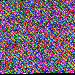

In [ ]:
X = np.random.rand(256, 16).astype(np.float32)       # docs × metrics
w = np.linspace(1, 2, X.shape[1]).astype(np.float32) # task weights
col_order = np.argsort(-np.abs(np.corrcoef(X, rowvar=False).sum(0)))
Xc = X[:, col_order]
row_order = np.argsort(-(Xc @ w[col_order]))
Y = Xc[row_order] 
tile = tensor_to_vpm(Y); tile.save("top_left.png")
from IPython.display import Image, display 

display(Image(filename="top_left.png"))


## 6. Compositional logic (visually).

Fuzzy AND/OR/NOT/XOR on tiles.


2025-08-13 21:31:21,239 - matplotlib - DEBUG - matplotlib data path: c:\Users\ernan\Project\zeromodel\venv\Lib\site-packages\matplotlib\mpl-data
2025-08-13 21:31:21,260 - matplotlib - DEBUG - CONFIGDIR=C:\Users\ernan\.matplotlib
2025-08-13 21:31:21,283 - matplotlib - DEBUG - interactive is False
2025-08-13 21:31:21,284 - matplotlib - DEBUG - platform is win32
2025-08-13 21:31:21,417 - matplotlib - DEBUG - CACHEDIR=C:\Users\ernan\.matplotlib
2025-08-13 21:31:21,426 - matplotlib.font_manager - DEBUG - Using fontManager instance from C:\Users\ernan\.matplotlib\fontlist-v390.json
2025-08-13 21:31:21,677 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-13 21:31:21,679 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-13 21:31:21,683 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
20

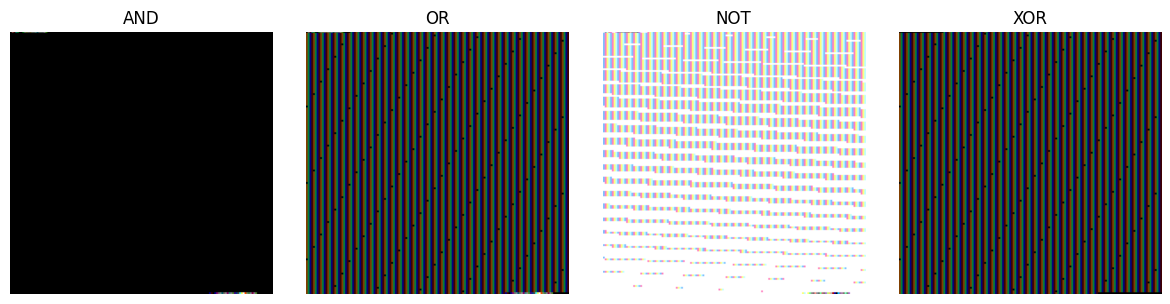

In [9]:
import matplotlib.pyplot as plt

imgs  = [
    vpm_logic_and(A, B),
    vpm_logic_or(A, B),
    vpm_logic_not(A),
    vpm_logic_xor(A, B),
]
titles = ["AND", "OR", "NOT", "XOR"]

plt.figure(figsize=(12,3))
for i, (img, title) in enumerate(zip(imgs, titles), 1):
    ax = plt.subplot(1, 4, i)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()


### 7. Deterministic, reproducible provenance.

Embed → extract → verify the fingerprint.


In [10]:
img = Image.new("RGB",(128,128),(8,8,8))
vpf = create_vpf(
  pipeline={"graph_hash":"sha3:demo","step":"render_tile"},
  model={"id":"demo","assets":{}},
  determinism={"seed":123,"rng_backends":["numpy"]},
  params={"size":[128,128]},
  inputs={"prompt_sha3": hashlib.sha3_256(b"hello").hexdigest()},
  metrics={"quality":0.99},
  lineage={"parents":[]},
)
png_bytes = embed_vpf(img, vpf, mode="stripe")
vpf_out, meta = extract_vpf(png_bytes)
print("verified:", verify_vpf(vpf_out, png_bytes))


verified: True


### 8. A universal, self-describing artifact (it’s just a PNG).

Two lines: write+read the self-contained tile.

In [16]:
def sha3_hex(b: bytes) -> str:
    return hashlib.sha3_256(b).hexdigest()

w = 512
h = 256
x = np.linspace(0, 1, w, dtype=np.float32)[None, :]
y = np.linspace(0, 1, h, dtype=np.float32)[:, None]
img = np.clip((0.6 * x + 0.4 * y), 0, 1)
rgb = (np.stack([img, img**0.5, img**2], axis=-1) * 255).astype(np.uint8)
img = Image.fromarray(rgb)


H = img.size[1]
Hvals = H - 4  # reserve top 4 rows for header
x = np.linspace(0, 1, Hvals, dtype=np.float32)
metrics_matrix = np.stack([
    0.5 + 0.5*np.sin(2*np.pi*3*x),
    0.5 + 0.5*np.cos(2*np.pi*5*x),
], axis=1)
metric_names = ["aesthetic", "coherence"]

# Build a minimal VPF dict
vpf = {
    "vpf_version": "1.0",
    "pipeline": {"graph_hash": "sha3:demo", "step": "render_tile"},
    "model": {"id": "demo", "assets": {}},
    "determinism": {"seed_global": 123, "rng_backends": ["numpy"]},
    "params": {"size": [img.size[0], img.size[1]], "steps": 28, "cfg_scale": 7.5},
    "inputs": {"prompt": "demo", "prompt_hash": sha3_hex(b"demo")},
    "metrics": {"aesthetic": float(metrics_matrix[:,0].mean()),
                "coherence": float(metrics_matrix[:,1].mean())},
    "lineage": {"parents": []}
}

# 1) Embed (writes stripe into pixels, appends footer)
png_with_footer = embed_vpf(
    img,
    vpf,
    stripe_metrics_matrix=metrics_matrix,
    stripe_metric_names=metric_names,
    stripe_channels=("R",),
)
# 2) Extract footer + quickscan metrics from stripe
extracted_vpf, quick = extract_vpf(png_with_footer)

print("extracted_vpf:", extracted_vpf)
print("quickscan metrics:", quick)

extracted_vpf: {'determinism': {'rng_backends': ['numpy'], 'seed_global': 123}, 'inputs': {'prompt': 'demo', 'prompt_hash': '7f23e6ca181cc91d57245809edb1097a1f14ed011e4a9520a8dd10aa3ef82789'}, 'lineage': {'content_hash': 'sha3:d5ab66b35abb4fd1d924e59115bbd1a3062293684cc320c78f38ab04dee4428f', 'parents': [], 'vpf_hash': 'sha3:616d492b45da75664a8767a3ae0df86abb9cfe33f12651792509f0ac5cb0a421'}, 'metrics': {'aesthetic': 0.5, 'coherence': 0.501984179019928}, 'model': {'assets': {}, 'id': 'demo'}, 'params': {'cfg_scale': 7.5, 'size': [512, 256], 'steps': 28}, 'pipeline': {'graph_hash': 'sha3:demo', 'step': 'render_tile'}, 'vpf_version': '1.0'}
quickscan metrics: {'embedding_mode': 'binary_footer'}


VPF hash: sha3:44723e021c5 …
Stripe width: None cols


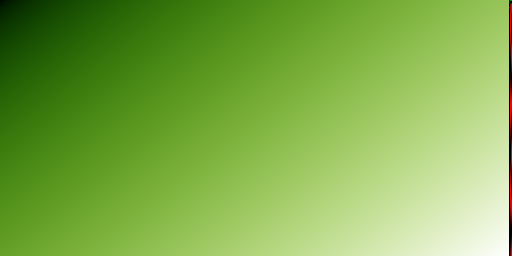

In [18]:
import numpy as np, hashlib
from PIL import Image

# tiny helper
sha3_hex = lambda b: hashlib.sha3_256(b).hexdigest()

# --- base image (nice RGB gradient) ---
w, h = 512, 256
x = np.linspace(0, 1, w)[None, :]
y = np.linspace(0, 1, h)[:,  None]
g = np.clip(0.6*x + 0.4*y, 0, 1)
img = Image.fromarray((np.stack([g, g**0.5, g**2], -1)*255).astype(np.uint8))

# --- two metric lanes across the height (H-4 usable rows) ---
t = np.linspace(0, 1, h-4, dtype=np.float32)
M = np.stack([0.5 + 0.5*np.sin(2*np.pi*3*t),
              0.5 + 0.5*np.cos(2*np.pi*5*t)], axis=1)
names = ["aesthetic", "coherence"]

# --- minimal VPF dict (content_hash/vpf_hash will be filled during embed) ---
vpf = {
    "vpf_version": "1.0",
    "pipeline": {"graph_hash": "sha3:demo", "step": "render_tile"},
    "model": {"id": "demo", "assets": {}},
    "determinism": {"seed_global": 123, "rng_backends": ["numpy"]},
    "params": {"size": [w, h]},
    "inputs": {"prompt": "demo", "prompt_hash": sha3_hex(b"demo")},
    "metrics": {n: float(M[:, i].mean()) for i, n in enumerate(names)},
    "lineage": {"parents": []},
}

# --- embed → bytes (right-edge stripe + VPF footer), then extract ---
blob = embed_vpf(
    img,
    vpf,
    stripe_metrics_matrix=M,
    stripe_metric_names=names,
    stripe_channels=("R",),   # keep the stripe single-channel
)
vpf_out, meta = extract_vpf(blob)

print("VPF hash:", vpf_out["lineage"]["vpf_hash"][:16], "…")
print("Stripe width:", meta.get("stripe_width"), "cols")

with open("ai_barcode_demo.png", "wb") as f: 
    f.write(blob)
from IPython.display import Image as _I, display; 
display(_I(data=blob))


### 9. Edge ↔ cloud symmetry.

Same tile: fast edge decision vs. full cloud inspection.


In [ ]:
tile = tensor_to_vpm(np.random.rand(64,64).astype(np.float32))
edge_decision = (tile.getpixel((0,0))[0] > 170)
cloud_matrix  = vpm_to_tensor(tile)  # inspect entire matrix if you want
print(edge_decision, cloud_matrix.shape)

False (64, 64)


### 10. Traceable “thought,” end-to-end.

Link steps via lineage parents.

In [23]:
vpfs = []
parent_ids = []
for step in range(3):
    v = create_vpf(
      pipeline={"graph_hash":"sha3:p","step":f"step{step}"},
      model={"id":"demo","assets":{}},
      determinism={"seed":0,"rng_backends":["numpy"]},
      params={"size":[64,64]},
      inputs={}, metrics={}, lineage={"parents": parent_ids.copy()},
    )
    vpfs.append(v); parent_ids = [hashlib.sha3_256(str(v).encode()).hexdigest()]
print("chain length:", len(vpfs), "parents of last:", vpfs[-1]["lineage"]["parents"])


chain length: 3 parents of last: ['9d38585a4eb980a53ccd7d43f463e8c776a322f3a1a37c89e2ab1670bd872245']


### 11. Multi-metric, multi-view by design.

Same data, different “lenses.”

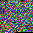

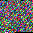

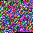

In [30]:
X = np.random.rand(128, 6).astype(np.float32)
w_search = np.array([3,2,2,1,1,1], np.float32)
w_safety = np.array([0,1,3,3,1,0], np.float32)
def view(weights): 
    return tensor_to_vpm(X[:, np.argsort(-weights)])
tensor_to_vpm(X).save("neutral.png")
view(w_search).save("search_view.png")
view(w_safety).save("safety_view_01.png")
from IPython.display import Image, display; 
display(Image(filename="neutral.png"))
display(Image(filename="search_view.png"))
display(Image(filename="safety_view_01.png"))


### 12. Storage-agnostic, pluggable routing.

Resolve child pointers however you like.

In [31]:
from zeromodel.vpm.metadata import RouterPointer, FilenameResolver
ptrs = [RouterPointer(kind=0, level=i, x_offset=0, span=1024, doc_block_size=1, agg_id=0, tile_id=bytes(16))
        for i in range(3)]
paths = [FilenameResolver().resolve(p.tile_id) for p in ptrs]
print(paths)


['vpm_00000000000000000000000000000000_L0_B1.png', 'vpm_00000000000000000000000000000000_L0_B1.png', 'vpm_00000000000000000000000000000000_L0_B1.png']


### 13. Cheap to adopt.

Already have scores? Encode in 2 lines.

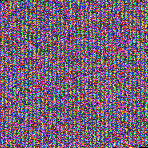

In [35]:
your_model_scores = np.random.rand(128, 128).astype(np.float32)
scores = your_model_scores.astype(np.float32)  # docs × metrics
tile = tensor_to_vpm(scores); tile.save("drop_in.png")
from IPython.display import Image, display; 
display(Image(filename="drop_in.png"))


### 14. Privacy-friendly + offline-ready.

Ship *scores*, not raw content; run offline.

In [36]:
scores = np.random.rand(256,8).astype(np.float32)  # no PII
png   = tensor_to_vpm(scores); png.save("offline_decision.png")

### 15. Human-compatible explanations.

Point to *where* the signal lives.

In [48]:
doc_a_for_metric_0 = 50
doc_b_for_metric_1 = 177
unique_high_val = 0.99 # A value very unlikely to be exceeded by random [0,1) data
num_docs = 200
num_metrics = 5

metric_names = ["aesthetic", "coherence", "relevance", "novelty", "utility"]

score_matrix = np.random.rand(num_docs, num_metrics).astype(np.float32)

score_matrix[doc_a_for_metric_0, 0] = unique_high_val # Metric 0
score_matrix[doc_b_for_metric_1, 1] = unique_high_val # Metric 1

# Simple SQL query for initial analysis (doesn't affect canonical sort)
sql_query = "SELECT * FROM virtual_index ORDER BY aesthetic DESC coherence ASC" # Placeholder
vpm_path = "canonical_vpm.png"
model = ZeroModel(metric_names=metric_names)
model.prepare(
    score_matrix=score_matrix,
    sql_query=sql_query,
    vpm_output_path=vpm_path
)
from IPython.display import Image, display; 
display(Image(filename="canonical_vpm.png", width=1200))

inv_model = ZeroModel(metric_names=metric_names)
sql_query = "SELECT * FROM virtual_index ORDER BY aesthetic ASC coherence DESC" # Placeholder
inv_vpm_path = "inv_canonical_vpm.png"
inv_model.prepare(
    score_matrix=score_matrix,
    sql_query=sql_query,
    vpm_output_path=inv_vpm_path
)
from IPython.display import Image, display; 
display(Image(filename="canonical_vpm.png", width=1200))


2025-08-13 22:26:53,009 - zeromodel.core - DEBUG - Initializing ZeroModel with metrics: ['aesthetic', 'coherence', 'relevance', 'novelty', 'utility'], config: {'use_duckdb': False, 'duckdb_bypass_threshold': 0.5, 'precision': 8, 'normalize_inputs': True, 'nonlinearity_handling': 'auto', 'cache_preprocessed_vpm': True, 'max_cached_tasks': 100, 'default_output_precision': 'float32'}
2025-08-13 22:26:53,020 - zeromodel.normalizer - DEBUG - Initializing DynamicNormalizer for 5 metrics
2025-08-13 22:26:53,021 - zeromodel.normalizer - INFO - Normalizer initialized with alpha=0.10 for metrics: ['aesthetic', 'coherence', 'relevance', 'novelty', 'utility']
2025-08-13 22:26:53,021 - zeromodel.vpm.encoder - DEBUG - VPMEncoder initialized with default output precision: float32
2025-08-13 22:26:53,022 - zeromodel.core - INFO - ZeroModel initialized with 5 metrics. Default output precision: float32.
2025-08-13 22:26:53,024 - zeromodel.core - INFO - Preparing ZeroModel with data shape (200, 5), query

2025-08-13 22:26:53,050 - zeromodel.core - DEBUG - Initializing ZeroModel with metrics: ['aesthetic', 'coherence', 'relevance', 'novelty', 'utility'], config: {'use_duckdb': False, 'duckdb_bypass_threshold': 0.5, 'precision': 8, 'normalize_inputs': True, 'nonlinearity_handling': 'auto', 'cache_preprocessed_vpm': True, 'max_cached_tasks': 100, 'default_output_precision': 'float32'}
2025-08-13 22:26:53,061 - zeromodel.normalizer - DEBUG - Initializing DynamicNormalizer for 5 metrics
2025-08-13 22:26:53,062 - zeromodel.normalizer - INFO - Normalizer initialized with alpha=0.10 for metrics: ['aesthetic', 'coherence', 'relevance', 'novelty', 'utility']
2025-08-13 22:26:53,063 - zeromodel.vpm.encoder - DEBUG - VPMEncoder initialized with default output precision: float32
2025-08-13 22:26:53,064 - zeromodel.core - INFO - ZeroModel initialized with 5 metrics. Default output precision: float32.
2025-08-13 22:26:53,064 - zeromodel.core - INFO - Preparing ZeroModel with data shape (200, 5), query

### 16. Robust under pressure.

CRC-checked stripe + versioned footer → detect tamper.

In [51]:
from PIL import Image
vpf = create_vpf(
    pipeline={"graph_hash":"sha3:p","step":f"step{step}"},
    model={"id":"demo","assets":{}},
    determinism={"seed":0,"rng_backends":["numpy"]},
    params={"size":[64,64]},
    inputs={}, metrics={}, lineage={"parents": parent_ids.copy()},
)
png_bytes = embed_vpf(Image.new("RGB",(64,64),(0,0,0)),
                      vpf, mode="stripe")
bad = bytearray(png_bytes); bad[-10] ^= 0xFF  # flip a bit
try:
    extract_vpf(bytes(bad))
    print("unexpected: extraction succeeded")
except Exception as e:
    print("tamper detected:", type(e).__name__)


tamper detected: error


### 18 Works with your stack, not against it.

Pandas → NumPy → VPM.

In [52]:
import pandas as pd
df = pd.DataFrame(np.random.rand(100,4), columns=list("ABCD"))
tile = tensor_to_vpm(df.to_numpy(dtype=np.float32))
tile.save("from_dataframe.png")


### 19. Great fits out of the box.

Quick triage: accept if “critical tile” is hot.

In [53]:
scores = np.random.rand(512, 10).astype(np.float32)
tile   = tensor_to_vpm(scores)
critical = np.mean(np.array(tile)[:8,:8,0])  # R-mean of 8×8
print("route:", "FAST_PATH" if critical>180 else "DEFER")


route: DEFER


### 20. A viewer you’ll actually use.

Click-through: map pixel → (row, metric) → explain.

In [54]:
tile = tensor_to_vpm(np.random.rand(256,16).astype(np.float32))
def explain(x,y):
    row, col = y, x
    print(f"doc#{row}, metric#{col}, value≈{tile.getpixel((x,y))[0]/255:.2f}")
explain(3,5)


doc#5, metric#3, value≈0.29
